# Section 1: Handwriting to Text Model

In [ ]:
# necessary imports

import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers as layers

from tqdm import tqdm
import csv

In [ ]:
# paths for datasets
sentences_txt_path = "/kaggle/input/iam-sentences/metadata/sentences.txt"
sentences_folder_path = "/kaggle/input/iam-sentences/dataset"

# load and process dataset
dataset, vocab, max_len = [], set(), 0
words = open(sentences_txt_path, "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[2] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = "-".join(line_split[0].split("-")[:2])
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip("\n")

    # replace "|" with " " in label
    label = label.replace("|", " ")

    rel_path = os.path.join(sentences_folder_path, file_name)
    if not os.path.exists(rel_path):
        print(f"File not found: {rel_path}")
        continue

    dataset.append([rel_path, label])
    max_len = max(max_len, len(label))

max_text_length = max_len


csv_file_path = "data.csv"

# write the data to CSV file with labeled columns
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(["path", "label"])
    writer.writerows(dataset)

print( csv_file_path + " has been created successfully.");

100%|██████████| 16777/16777 [00:19<00:00, 859.57it/s] 


data.csv has been created successfully.


In [ ]:
# creating pandas dataframe of dataset
data = pd.read_csv("/kaggle/working/data.csv")
data.head()

,path,label
0,/kaggle/input/iam-sentences/dataset/a01-000u-s...,A MOVE to stop Mr. Gaitskell from
1,/kaggle/input/iam-sentences/dataset/a01-000u-s...,nominating any more Labour life Peers
2,/kaggle/input/iam-sentences/dataset/a01-000u-s...,is to be made at a meeting of Labour
3,/kaggle/input/iam-sentences/dataset/a01-000u-s...,put down a resolution on the subject
4,/kaggle/input/iam-sentences/dataset/a01-000u-s...,P for Manchester Exchange .


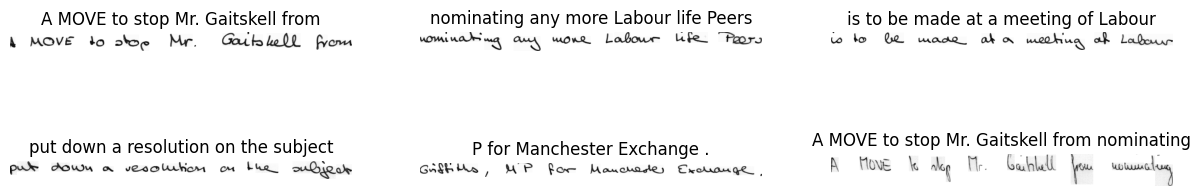

In [ ]:
# few example images of dataset

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = data.loc[i, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(data.loc[i, 'label'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
# dataset cleaning

print("Number of NaNs in train set      : ", data['label'].isnull().sum())
data.dropna(axis=0, inplace=True)

data['label'] = data['label'].str.upper()
data.reset_index(inplace = True, drop=True)

Number of NaNs in train set      :  3


In [ ]:
# label statistics

train_y_labels_max=0
train_y_labels_sum=0
train_y_labels_count_freq={}
for i in range(len(data)):
    freq=len(data.loc[i,'label'])
    if freq in train_y_labels_count_freq:
        train_y_labels_count_freq[freq]=train_y_labels_count_freq[freq]+1
    else:
        train_y_labels_count_freq[freq]=1
    if freq>train_y_labels_max:
        train_y_labels_max=freq
    train_y_labels_sum = train_y_labels_sum+freq

print('max len:', train_y_labels_max)
print('avg len:', train_y_labels_sum/len(data))

max len: 93
avg len: 34.388991477272725


<BarContainer object of 79 artists>

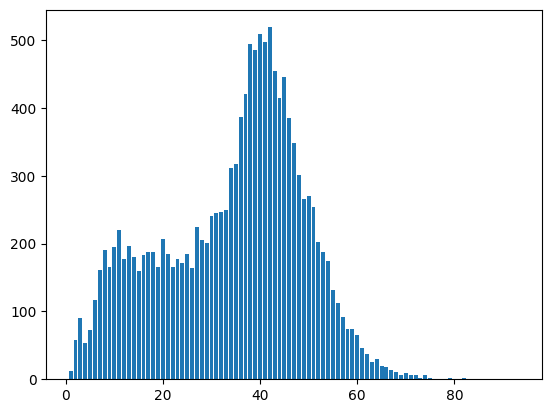

In [ ]:
plt.bar(list(train_y_labels_count_freq.keys()),list(train_y_labels_count_freq.values()))

In [ ]:
# augmenting images to improve model + prevent overfitting

# image augmentation function 1 (unused)
'''def augment_image1(image):
    # random gaussian blur
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 0)  # horizontal flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)  # vertical flip

    if np.random.rand() < 0.7:
        kernel_size = tuple(np.random.randint(3, 6, 2) * 2 + 1)
        #kernel_size = tuple(np.random.randint(3, 12, 2) * 2 + 1)
        image = cv2.GaussianBlur(image, kernel_size, 0)

    # random brightness adjustment
    if np.random.rand() < 0.7:
        brightness_factor = np.random.uniform(0.8, 1.1)
        image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    # random contrast adjustment
    if np.random.rand() < 0.7:
        contrast_factor = np.random.uniform(0.3, 1.3)
        image = np.clip((image - 127.5) * contrast_factor + 127.5, 0, 255).astype(np.uint8)

    # random saturation adjustment
    if np.random.rand() < 0.7:
        saturation_factor = np.random.uniform(0.3, 1.3)
        hsv_image = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
        hsv_image[..., 1] = np.clip(hsv_image[..., 1] * saturation_factor, 0, 255)
        # extracting the value (brightness) channel from the HSV image
        image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)[:, :, 2]

    rows, cols = image.shape
    shear_angle_x = np.random.uniform(-0.8, 0.8)  # range for x-axis shear (-0.2 to 0.2 rads)
    shear_matrix_x = np.float32([[1, shear_angle_x, 0], [0, 1, 0]])
    sheared_image = cv2.warpAffine(image.copy(), shear_matrix_x, (cols, rows))

    return sheared_image'''


# image augmentation function 2 (used)
def augment_image2(image):

    if np.random.rand() < 0.7:
        kernel_size = tuple(np.random.randint(3, 6, 2) * 2 + 1)
        #kernel_size = tuple(np.random.randint(3, 12, 2) * 2 + 1)
        image = cv2.GaussianBlur(image, kernel_size, 0)

    # random brightness adjustment
    if np.random.rand() < 0.7:
        brightness_factor = np.random.uniform(0.8, 1.1)
        image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    # random contrast adjustment
    if np.random.rand() < 0.7:
        contrast_factor = np.random.uniform(0.3, 1.3)
        image = np.clip((image - 127.5) * contrast_factor + 127.5, 0, 255).astype(np.uint8)

    # random saturation adjustment
    if np.random.rand() < 0.7:
        saturation_factor = np.random.uniform(0.3, 1.3)
        hsv_image = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
        hsv_image[..., 1] = np.clip(hsv_image[..., 1] * saturation_factor, 0, 255)
        # extracting the value (brightness) channel from HSV image
        image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)[:, :, 2]

    rows, cols = image.shape
    shear_angle_x = np.random.uniform(-0.8, 0.8)  # range for x-axis shear (-0.2 to 0.2 rads)
    shear_matrix_x = np.float32([[1, shear_angle_x, 0], [0, 1, 0]])
    sheared_image = cv2.warpAffine(image.copy(), shear_matrix_x, (cols, rows))

    return sheared_image

def resize_or_pad_image(image, target_height=64, target_width=512):
    image = cv2.resize(image, (target_width, target_height))
    return image


# resizing + rotating
def preprocess(img):
    (h, w) = img.shape
    final_image = resize_or_pad_image(img)
    return cv2.rotate(final_image, cv2.ROTATE_90_CLOCKWISE)


# resizing + augmenting
def preprocess1(img):
    (h, w) = img.shape
    final_image = resize_or_pad_image(img)
    return augment_image2(final_image)


In [ ]:
# validating resize_or_pad_image function

for i in range(5):
    image = cv2.imread(data.loc[i,'path'])
    image = resize_or_pad_image(image)
    image_shape = image.shape

    print("Shape of the image:", image_shape)

Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)


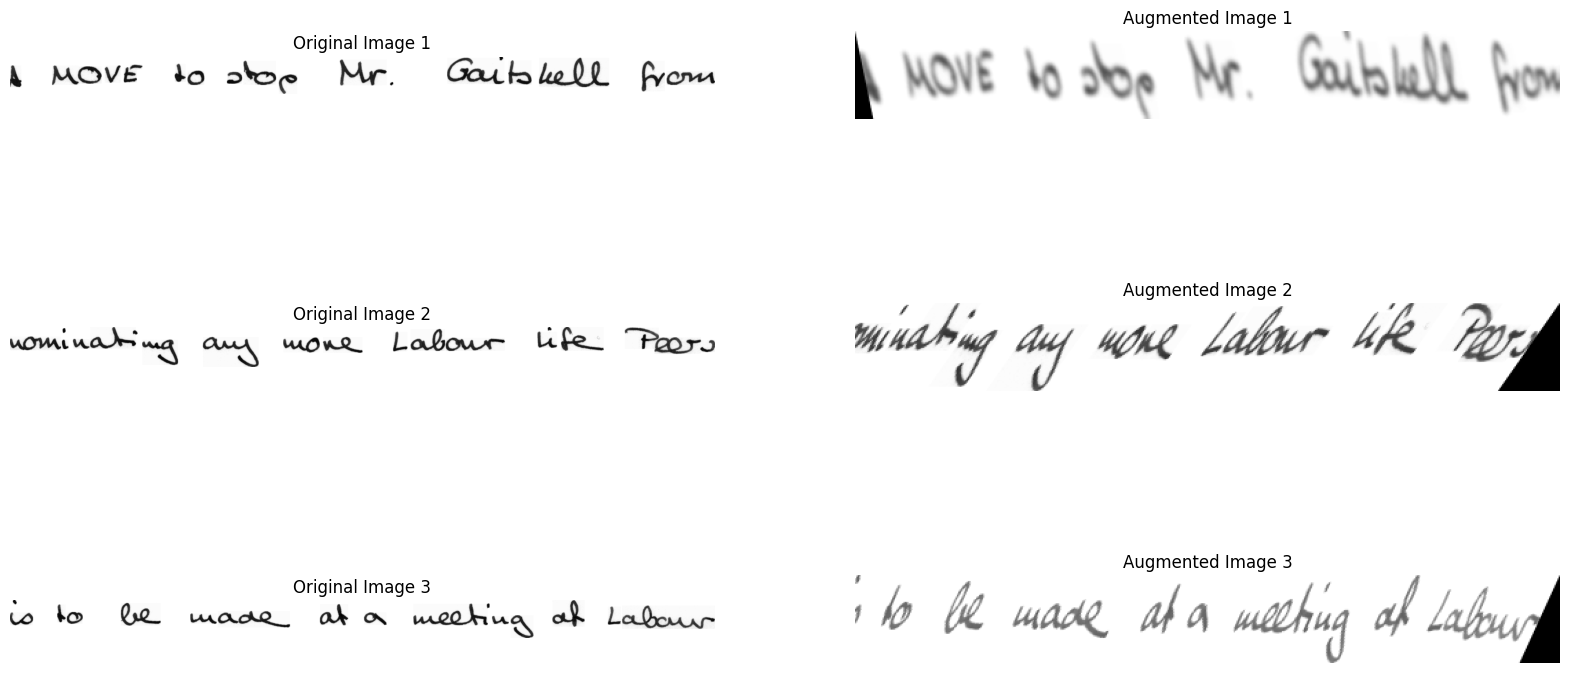

In [ ]:
# validating augmentation function

# example list of paths
img_paths = ['/kaggle/input/iam-sentences/dataset/a01-000u-s00-00.png',
             '/kaggle/input/iam-sentences/dataset/a01-000u-s00-01.png',
             '/kaggle/input/iam-sentences/dataset/a01-000u-s00-02.png']

plt.figure(figsize=(20, 10))

for i in range(3):
    img_path = img_paths[i]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    aug_img = preprocess1(img)
    # print(1)
    plt.subplot(3, 2, i * 2 + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original Image {i + 1}')
    plt.axis('off')

    plt.subplot(3, 2, i * 2 + 2)
    plt.imshow(aug_img, cmap='gray')
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')

plt.show()

In [ ]:
len(data)

14080

In [ ]:
# choosing dataset split size

train_size = 12080
valid_size = 1000
test_size = 1000

img_aug_count = 0

In [ ]:
# training data

train_x = []

for i in range(train_size):
    img_dir = data.loc[i, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

    t=image
    if random.randint(0, 10) in [1,2,3,4,5]:
        t= augment_image2(t)
        img_aug_count=img_aug_count+1

    t = preprocess(t)
    t = t/255.
    train_x.append(t)

In [ ]:
# validation data

valid_x = []

for i in range(train_size,train_size+valid_size):
    img_dir = data.loc[i, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [ ]:
# testing data

test_x = []

for i in range(train_size+valid_size,train_size+test_size+valid_size):
    img_dir = data.loc[i, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    test_x.append(image)

In [ ]:
print('train:',len(train_x),'valid:',len(valid_x),'test:',len(test_x))

train: 12080 valid: 1000 test: 1000


In [ ]:
np.asarray(train_x).shape

(12080, 512, 64)

In [ ]:
# reshaping data

train_x = np.array(train_x).reshape(-1, 512, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 512, 64, 1)
test_x = np.array(test_x).reshape(-1, 512, 64, 1)

In [ ]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-,!?.' " # alphabets our model can identify
max_str_len = 95 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 128 # max length of predicted labels


# encode + decode functions
def label_to_num(label):
    label_num = []
    for ch in label:
        ind=alphabets.find(ch)
        if ind != -1:
            label_num.append(ind)
        else:
            label_num.append(0)
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
# validating encoder
name = 'THREESV'
print(name, '\n',label_to_num(name))

THREESV 
 [19  7 17  4  4 18 21]


In [ ]:
train_y = np.ones([train_size,max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(data.loc[i, 'label'])
    train_y[i, 0:len(data.loc[i, 'label'])]= label_to_num(data.loc[i, 'label'])

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(train_size,train_size+valid_size):
    valid_label_len[i-train_size] = len(data.loc[i, 'label'])
    valid_y[i-train_size, 0:len(data.loc[i, 'label'])]= label_to_num(data.loc[i, 'label'])

In [ ]:
test_y = np.ones([test_size, max_str_len]) * -1
test_label_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * (num_of_timestamps-2)
test_output = np.zeros([test_size])

for i in range(train_size+valid_size,train_size+valid_size+test_size):
    test_label_len[i-(train_size+valid_size)] = len(data.loc[i, 'label'])
    test_y[i-(train_size+valid_size), 0:len(data.loc[i, 'label'])]= label_to_num(data.loc[i, 'label'])

In [ ]:
# example of encoding

print('True label : ',data.loc[10, 'label'] , '\ntrain_y : ',train_y[10],'\ntrain_label_len : ',train_label_len[10], '\ntrain_input_len : ', train_input_len[10])

True label :  AND HE IS TO BE BACKED BY MR. WILL GRIFFITHS , 
train_y :  [ 0. 13.  3. 32.  7.  4. 32.  8. 18. 32. 19. 14. 32.  1.  4. 32.  1.  0.
  2. 10.  4.  3. 32.  1. 24. 32. 12. 17. 30. 32. 22.  8. 11. 11. 32.  6.
 17.  8.  5.  5.  8. 19.  7. 18. 32. 27. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1.] 
train_label_len :  [46.] 
train_input_len :  [126.]


In [ ]:
# MobileNetV2 approach (unused)
# from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2 pre-trained on ImageNet, excluding the top layers
# mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 64, 3))

# Freeze the pre-trained layers to prevent them from updating during training
# mobilenet_v2.trainable = False

# from tensorflow.keras.layers import Concatenate,Flatten


################ model 1 (MobileNetV2 approach (unused))

# # mobilenetv2
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import Concatenate,Flatten

# input_data = Input(shape=(512, 64, 1), name='input')
# x = Concatenate()([input_data, input_data, input_data])

# # Load MobileNetV2 without the top (classification) layers

# # Pass input through MobileNetV2
# mobilenet_output = mobilenet_v2(x)



# # Additional layers after feature extraction
# inner = Flatten()(mobilenet_output)
# inner = Dropout(0.4)(inner)

# # inner = Dense(64, activation='relu', name='dense1')(inner)

# # CNN to RNN
# inner = Reshape(target_shape=(128, 320), name='reshape')(inner)
# inner = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# # LSTM layers
# inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)

# inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

# # Output layer
# y_pred = Dense(num_of_characters, activation='softmax', name='output')(inner)

# # # Create model
# model = Model(inputs=input_data, outputs=y_pred)
# model.summary()

In [ ]:
# crnn approach

################# model 2 (crnn approach (used))
input_data = Input(shape=(512, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.5)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = Conv2D(128, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)


inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.5)(inner)

# CNN to RNN
inner = Reshape(target_shape=((128, 1024)), name='reshape')(inner)
inner = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 512, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 512, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 256, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 256, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 128, 16, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128, 16, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 128, 16, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 128, 16, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 16, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128, 16, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 128, 8, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128, 8, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 128, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (Bidirectional)           │ (None, 128, 512)       │       788,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (Bidirectional)           │ (None, 128, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128, 34)        │        17,442 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 128, 34)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753,186 (10.50 MB)

 Trainable params: 2,752,738 (10.50 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
######################### model 3 (squeezenet approach (unused))
# from tensorflow.keras.layers import Concatenate, Conv2D, MaxPooling2D, Flatten, Reshape, Dense, LSTM, Bidirectional, Input, Activation

# def fire_module(x, fire_id, squeeze=16, expand=64):
#     """
#     Create a fire module with squeeze and expand layers.
#     """
#     squeeze_channels = squeeze
#     expand1_channels = expand
#     expand3_channels = expand

#     # Squeeze layer
#     squeeze_layer = Conv2D(squeeze_channels, (1, 1), activation='relu', padding='same', name='fire{}_squeeze'.format(fire_id))(x)

#     # Expand layer 1x1
#     expand1_layer = Conv2D(expand1_channels, (1, 1), activation='relu', padding='same', name='fire{}_expand1x1'.format(fire_id))(squeeze_layer)

#     # Expand layer 3x3
#     expand3_layer = Conv2D(expand3_channels, (3, 3), activation='relu', padding='same', name='fire{}_expand3x3'.format(fire_id))(squeeze_layer)

#     # Concatenate the outputs
#     output = Concatenate(axis=-1, name='fire{}_concatenate'.format(fire_id))([expand1_layer, expand3_layer])

#     return output

# # Define input shape
# input_data = Input(shape=(512, 64, 1), name='input')

# # SqueezeNet architecture
# conv1 = Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='valid', name='conv1')(input_data)
# pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(conv1)

# fire2 = fire_module(pool1, fire_id=2, squeeze=16, expand=64)
# fire3 = fire_module(fire2, fire_id=3, squeeze=16, expand=64)
# pool3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(fire3)
# pool3 = Dropout(0.4)(pool3)

# fire4 = fire_module(pool3, fire_id=4, squeeze=32, expand=128)
# fire5 = fire_module(fire4, fire_id=5, squeeze=32, expand=128)
# pool5 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(fire5)
# pool5 = Dropout(0.4)(pool5)

# fire6 = fire_module(pool5, fire_id=6, squeeze=48, expand=192)
# fire7 = fire_module(fire6, fire_id=7, squeeze=48, expand=192)
# fire8 = fire_module(fire7, fire_id=8, squeeze=64, expand=256)
# fire8 = Dropout(0.4)(fire8)

# # Flatten and Dense layers
# flatten = Flatten(name='flatten')(fire8)
# # dense1 = Dense(512, activation='relu', name='dense1')(flatten)

# # Reshape for LSTM
# reshaped_output = Reshape(target_shape=(128, 372))(flatten)
# inner = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense1')(reshaped_output)

# # LSTM layers
# lstm1 = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
# lstm2 = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(lstm1)

# # Output layer
# y_pred = Dense(num_of_characters, activation='softmax', name='output')(lstm2)

# # Create model
# model = Model(inputs=input_data, outputs=y_pred)
# model.summary()

In [ ]:
###################### model 4 (MobileNetV2 model (unused))
# # mobilenetv2
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import Concatenate,Flatten

# input_data = Input(shape=(512, 64, 1), name='input')
# x = Concatenate()([input_data, input_data, input_data])

# # Load MobileNetV2 without the top (classification) layers
# mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 64, 3))

# # Pass input through MobileNetV2
# mobilenet_output = mobilenet_v2(x)

# # Additional layers after feature extraction
# inner = Flatten()(mobilenet_output)
# inner = Dropout(0.4)(inner)

# # inner = Dense(64, activation='relu', name='dense1')(inner)

# # CNN to RNN
# inner = Reshape(target_shape=(128, 320), name='reshape')(inner)
# inner = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# # LSTM layers
# inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)

# inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

# # Output layer
# y_pred = Dense(num_of_characters, activation='softmax', name='output')(inner)

# # Create model
# model = Model(inputs=input_data, outputs=y_pred)
# model.summary()

In [ ]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)
model_final.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 512, 64,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 512, 64,   │        320 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 64,   │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 512, 64,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max1 (MaxPooling2D) │ (None, 256, 32,   │          0 │ activation_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 256, 32,   │     18,496 │ max1[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32,   │        256 │ conv2[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 256, 32,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max2 (MaxPooling2D) │ (None, 128, 16,   │          0 │ activation_4[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 16,   │          0 │ max2[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 128, 16,   │     73,856 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv4 (Conv2D)      │ (None, 128, 16,   │    147,584 │ conv3[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 16,   │        512 │ conv4[0][0]       │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 128, 16,   │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max3 (MaxPooling2D) │ (None, 128, 8,    │          0 │ activation_5[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 8,    │          0 │ max3[0][0]        │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 1024) │          0 │ dropout_3[0][0] 

 Total params: 2,753,186 (10.50 MB)

 Trainable params: 2,752,738 (10.50 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# we are using a dummy lambda function, since loss calculation happens elsewhere
optimizer = Adam(learning_rate=0.001)
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

history=model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
                validation_data=([valid_x, valid_y, valid_input_len,  valid_label_len], valid_output),
                epochs=80, batch_size=64,verbose=1)
# ,callbacks=[early_stopping]

Epoch 1/80


2024-04-24 16:11:43.093068: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_7_1/dropout_2_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


189/189 ━━━━━━━━━━━━━━━━━━━━ 47s 216ms/step - loss: 113.3528 - val_loss: 82.9852
Epoch 2/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 211ms/step - loss: 74.3124 - val_loss: 47.3864
Epoch 3/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 210ms/step - loss: 52.9081 - val_loss: 35.6509
Epoch 4/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 210ms/step - loss: 41.4927 - val_loss: 26.5862
Epoch 5/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 210ms/step - loss: 35.1975 - val_loss: 23.1426
Epoch 6/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 210ms/step - loss: 30.4545 - val_loss: 20.3899
Epoch 7/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 211ms/step - loss: 26.8632 - val_loss: 19.3772
Epoch 8/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 210ms/step - loss: 24.3514 - val_loss: 17.3023
Epoch 9/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 210ms/step - loss: 22.4036 - val_loss: 15.8237
Epoch 10/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 210ms/step - loss: 20.4968 - val_loss: 15.1132
Epoch 11/80
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 210ms/step - loss: 18.7678 - val_loss: 14.8933
Epoch 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


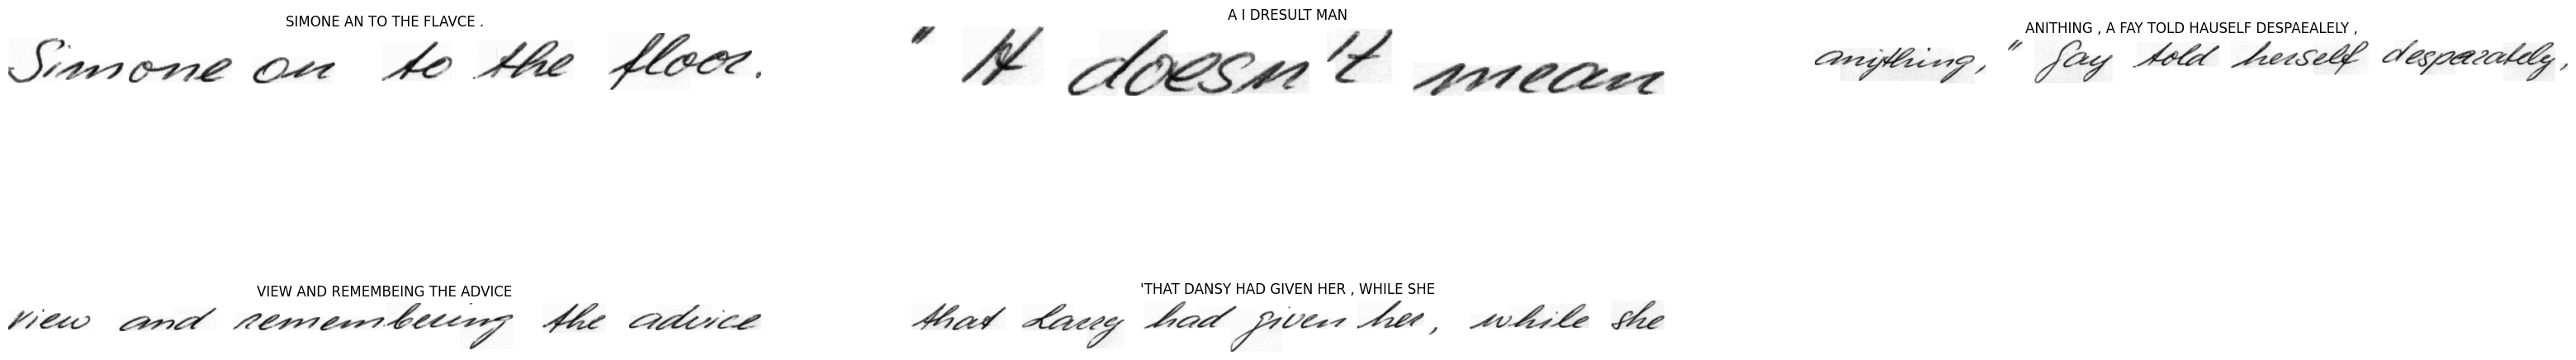

In [ ]:
# prediction examples
plt.figure(figsize=(40, 25))
for i in range(0,5):
    ax = plt.subplot(2, 3, i+1)
    img_dir = data.loc[i+train_size+valid_size, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 512, 64, 1))
    decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

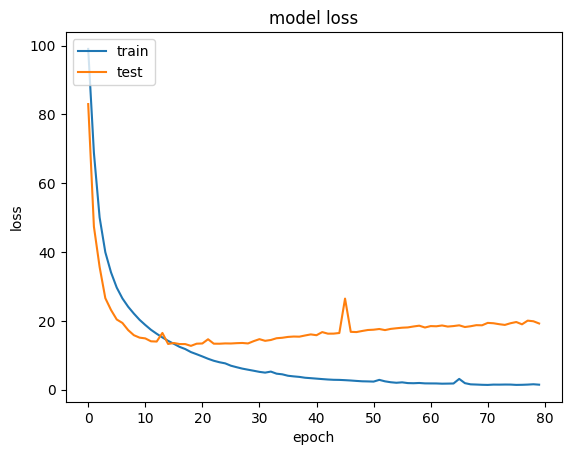

In [ ]:
# model loss graph

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save_weights('threesv.weights.h5')

In [ ]:
# prediction array preparation
preds = model.predict(test_x)
decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=True)[0][0])

prediction = []
for i in range(test_size):
    prediction.append(num_to_label(decoded[i]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [ ]:
# attempt to implement word beam search (unused)
temp = '''# Define the Word Beam Search decoding function
def word_beam_search(prediction, beam_width=25, lm=None):
    # Replace alphabet with your alphabet if it's different
    # alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    # alphabet = alphabets
    alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 "

    blank_idx = len(alphabet)
    space_idx = len(alphabet) - 1


    if lm is not None:
        # Load language model if available
        lm = open(lm_path).read().split()
        lm = {lm[i]: float(lm[i + 1]) for i in range(0, len(lm), 2)}

    print(prediction.shape)
    V, T = prediction.shape  # T: input len, V: number of labels (including blank)

    # Step 1: Initialize variables
    paths = {'': 0}

    # Step 2: Decode each time step
    for t in range(T):
        new_paths = {}

        # Beam search
        for path in paths:
            # Insert blank
            if path in new_paths:
                new_paths[path] += prediction[t, blank_idx] * paths[path]
            else:
                new_paths[path] = prediction[t, blank_idx] * paths[path]

            # Insert character
            idx = np.argmax(prediction[t, :])
            char = alphabet[idx]
            if char != '':
                if path in new_paths:
                    new_paths[path + char] += prediction[t, idx] * paths[path]
                else:
                    new_paths[path + char] = prediction[t, idx] * paths[path]

            # Insert space
            if char != '' and char != ' ':
                if len(path) > 0 and path[-1] != ' ':
                    if path + ' ' in new_paths:
                        new_paths[path + ' '] += prediction[t, space_idx] * paths[path]
                    else:
                        new_paths[path + ' '] = prediction[t, space_idx] * paths[path]

        # Prune paths
        ordered_paths = sorted(new_paths.items(), key=lambda x: x[1], reverse=True)[:beam_width]
        paths = {k: v for k, v in ordered_paths}

    # Apply language model if available
    if lm is not None:
        for path in paths:
            words = path.strip().split()
            score = sum([np.log(lm[w] if w in lm else 0.01) for w in words])
            paths[path] *= np.exp(score)

    # Select the most likely path
    best_path = max(paths, key=paths.get)
    return best_path.strip()

# Implementing Word Beam Search decoding for the predictions
def decode_with_wbs(predictions):
    decoded_texts = []
    for pred in predictions:
        decoded = word_beam_search(pred)
        decoded_texts.append(decoded)
    return decoded_texts


preds = model.predict(test_x)

# print(preds.shape)
prediction = []

decoded_predictions = decode_with_wbs(preds)
for text in decoded_predictions:
    prediction.append(text)'''

In [ ]:
# calculating word, character accuracy
y_true = data.loc[train_size+valid_size:train_size+valid_size+test_size, 'label']


def calculate_accuracy(y_true, y_pred):
    total_words = 0
    correct_words = 0
    total_char = 0
    correct_char = 0

    for true_sentence, pred_sentence in zip(y_true, y_pred):
        true_words = true_sentence.split()
        pred_words = pred_sentence.split()


        total_words += len(true_words)

        # word accuracy
        for true_word, pred_word in zip(true_words, pred_words):
            if true_word == pred_word:
                correct_words += 1

            total_char += len(true_word)

            # character accuracy
            for j in range(min(len(true_word), len(pred_word))):
                if true_word[j] == pred_word[j]:
                    correct_char += 1

    word_accuracy = correct_words / total_words if total_words > 0 else 0
    character_accuracy = correct_char/ total_char if total_char> 0 else 0

    return word_accuracy, character_accuracy


word_accuracy, character_accuracy = calculate_accuracy(y_true, prediction)
print("Word Accuracy:", word_accuracy)
print("Character Accuracy:", character_accuracy)

Word Accuracy: 0.5847882192196752
Character Accuracy: 0.7167569737106161


# Section 2: Answer Script Evaluation

In [ ]:
# self-curated dataset of handwritten answer scripts
folderpath='/kaggle/input/handwritten-answers-zip/Handwritten_Answers'

# function to extract data from filenames
    # if the roll number starts with Correct, it is a correct answer
    # if it starts with Incorrect, it is a wrong answer
    #### we have added the correctness of data into the roll number to make it easier to understand and calculate accuracy
def extract_data(filename):
    parts = filename.split("_")
    if len(parts) != 4:
        raise ValueError("Invalid filename format")
    question_number = parts[1]
    correctness = parts[3]

    correctness, _ = correctness.split(".")

    if correctness == 'C':
        roll_number = 'Correct_'+parts[2]
    else:
        roll_number = 'Incorrect_'+parts[2]

    return question_number, roll_number, correctness

# function to write data into a csv
def write_to_csv(filenames, csv_filename):
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Question Number", "Roll Number", "Correctness", "Filepath"])
        for filename in filenames:
            try:
                question_number, roll_number, correctness = extract_data(filename)
                filepath = folderpath + '/' + filename
                writer.writerow([question_number, roll_number, correctness, filepath])
            except ValueError as e:
                print(f"Error processing file {filename}: {e}")

# function to get list of filenames
def get_filelist(folder_path):
    filelist = []
    for filename in os.listdir(folder_path):
        filelist.append(filename)
    return filelist

In [ ]:
# creates csv and data frame of data
filenames = get_filelist(folderpath)
csv_filename = "answer_scripts.csv"
write_to_csv(filenames, csv_filename)
df = pd.read_csv("answer_scripts.csv")

In [ ]:
# preprocessing answer scripts
processed_images = []
p_dataset = df["Filepath"].tolist()

for i in p_dataset:
    image = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    processed_images.append(image)

processed_images = np.array(processed_images).reshape(-1, 512, 64, 1)

In [ ]:
# digitizing answer scripts by running our model on it

ans = model.predict(processed_images)
p_decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(ans, input_length=np.ones(ans.shape[0])*ans.shape[1], greedy=True)[0][0])

# decoding and preparing prediction string array
p_prediction = []
for i in range(len(p_decoded)):
    x = num_to_label(p_decoded[i])
    # print(x)
    nx=''
    for e in x:
        if e == "'" or e == ".":
            continue
        else:
            nx+=e
    p_prediction.append(nx.strip())

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [ ]:
df['Student Answer'] = p_prediction

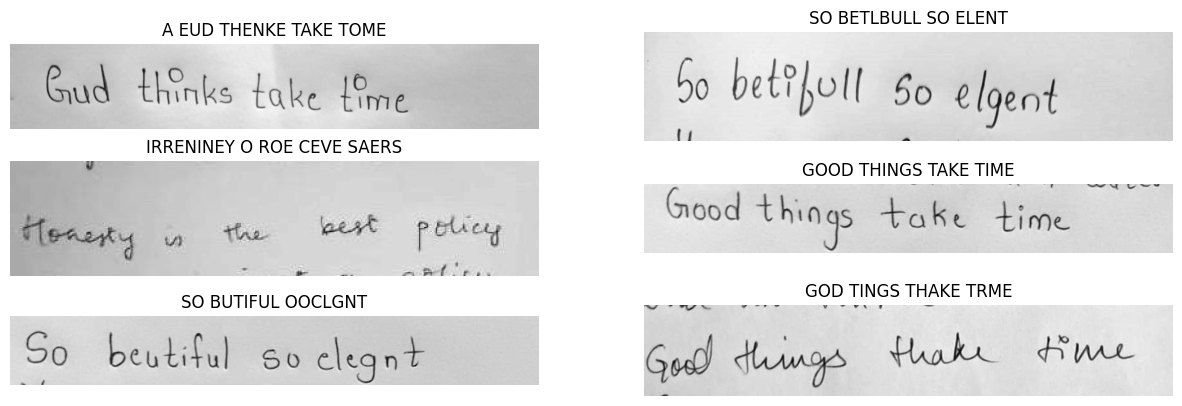

In [ ]:
# display answer script image, expected answer and model prediction

plt.figure(figsize=(15, 12))

for i in range(0, 6):
    ax = plt.subplot(3, 2, i+1)
    img_dir = df.loc[i, 'Filepath']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(df.loc[i, 'Student Answer'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
# pip install necessary modules
%pip install python-Levenshtein

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# function that awards students scores based on the Levenshtein distance from expected answers
import Levenshtein

def evaluate_answers(df, expected):
    df['Score'] = None

    for index, row in df.iterrows():
        question_number = row['Question Number'] - 1
        expected_answer = expected[question_number]
        student_answer = row['Student Answer']
        df.at[index, 'Score'] = Levenshtein.distance(expected_answer, student_answer)

    return df

expected = ['SO BEAUTIFUL SO ELEGANT', 'YOU ARE MY SUNSHINE', 'HONESTY IS THE BEST POLICY','BLOOD IS THICKER THAN WATER', 'GOOD THINGS TAKE TIME']

df = evaluate_answers(df.copy(), expected)
mean = df['Score'].mean()

In [ ]:
# column of our evaluated answer
def predict_from_score(score):
    return 'W' if score > mean else 'C'

df['Evaluated Answer'] = df['Score'].apply(predict_from_score)

In [ ]:
# checking if our predictions are correct or wrong

correct_predictions = (df['Evaluated Answer'] == df['Correctness']).sum()
total_predictions = len(df)

accuracy = correct_predictions * 100 / total_predictions
accuracy = round(accuracy, 2)
print("Accuracy of evaluation: ", accuracy,"%")

Accuracy of evaluation:  57.95 %
